In [1]:
import torch
import pennylane as qml
import pennylane.ops as qmlops
import pennylane.templates as qmlt
from typing import TypedDict, Literal, Optional

In [ ]:
class PennyLaneArgs(TypedDict):
    hadamard: Optional[bool]
    encoder: Literal["angle", "amplitude"]
    angle_rot: Optional[Literal["X", "Y", "Z"]]
    entangler: Literal["basic", "strong"]
    rot: Optional[Literal["X", "Y", "Z"]]
    imprimitive: Optional[Literal["X", "Y", "Z"]]

In [2]:
q_device = "default.qubit"
n_qubits = 4
n_layers = 2
pennylane_args: PennyLaneArgs = {
    "hadamard": False,
    "encoder": "angle",
    "angle_rot": "Z",
    "entangler": "strong",
    "rot": "X",
    "imprimitive": "Z",
}

In [3]:
hadamard = pennylane_args.get("hadamard", False)
encoder = pennylane_args.get("encoder", "angle")
angle_rot = pennylane_args.get("angle_rot", "Z")
rot = pennylane_args.get("rot", "Z")
entangler = pennylane_args.get("entangler", "basic")
imprimitive = pennylane_args.get("imprimitive", qml.ops.CNOT)

if q_device == "default.qubit.torch":
    dev = qml.device(q_device, wires=n_qubits, torch_device="cuda")
else:
    dev = qml.device(q_device, wires=n_qubits)

if rot == "X":
    rot = qml.RX
elif rot == "Y":
    rot = qml.RY
else:
    rot = qml.RZ

if imprimitive == "X":
    imprimitive = qml.CNOT
elif imprimitive == "Y":
    imprimitive = qml.CY
else:
    imprimitive = qml.CZ


@qml.qnode(dev, interface="torch")
def qlayer(inputs, weights):
    if hadamard:
        qml.Hadamard(wires=range(n_qubits))
    if encoder == "angle":
        qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation=angle_rot)
    else:
        qmlt.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    if entangler == "strong":
        qmlt.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    else:
        qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits), rotation=rot)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [7]:
inputs = torch.randn(n_qubits)
shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
print(shape)
weights = torch.randn(shape)

(2, 4, 3)


0: ──RZ(-0.27)──Rot(-2.31,1.15,1.48)──╭●───────╭X──Rot(-0.80,-0.16,0.54)─╭●────╭X────┤  <Z>
1: ──RZ(0.61)───Rot(1.81,-2.18,1.71)──╰X─╭●────│───Rot(-1.43,0.44,-0.39)─│──╭●─│──╭X─┤  <Z>
2: ──RZ(-0.15)──Rot(1.00,-0.84,-0.58)────╰X─╭●─│───Rot(-0.77,-1.87,0.45)─╰X─│──╰●─│──┤  <Z>
3: ──RZ(-1.10)──Rot(-1.25,1.00,-2.56)───────╰X─╰●──Rot(-0.03,0.29,-1.29)────╰X────╰●─┤  <Z>


/group/pmc026/nchoong/qt/lib/python3.11/site-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(
/group/pmc026/nchoong/qt/lib/python3.11/site-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(


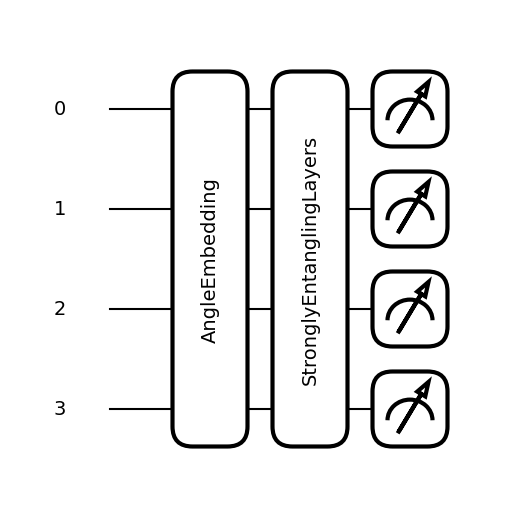

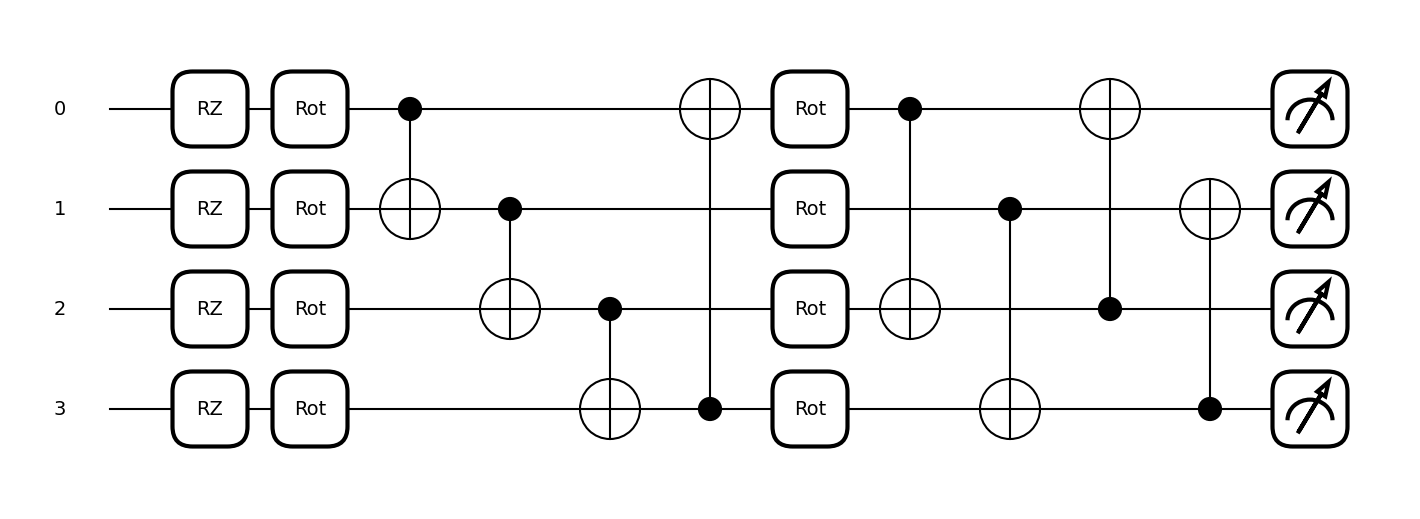

In [8]:
print(qml.draw(qlayer, expansion_strategy="device")(inputs, weights))
fig1, ax = qml.draw_mpl(qlayer)(inputs, weights)
fig2, ax = qml.draw_mpl(qlayer, expansion_strategy="device")(inputs, weights)

In [21]:
import numpy as np

np.random.seed(42)
n = 1

input_matrix = np.random.randn(2**n, 2**n)

ancilla_wires = ["ancilla"]

s = int(np.log2(input_matrix.shape[0]))
print(input_matrix.shape)
print("Elements in the matrix: ", 2**n * 2**n)
print(s)
wires_i = [f"i{index}" for index in range(s)]
wires_j = [f"j{index}" for index in range(s)]


input_matrix = input_matrix / np.max(np.abs(input_matrix))
dev = qml.device("default.qubit", wires=ancilla_wires + wires_i + wires_j)


@qml.qnode(dev, interface="torch")
def qlayer(inputs, weights):
    qmlt.FABLE(inputs, wires=ancilla_wires + wires_i + wires_j, tol=0)
    qmlt.StronglyEntanglingLayers(weights, wires=ancilla_wires + wires_i)
    return [qml.expval(qml.PauliZ(wires=i)) for i in ancilla_wires + wires_i]

(2, 2)
Elements in the matrix:  4
1


In [23]:
shape = qml.StronglyEntanglingLayers.shape(
    n_layers=n_layers, n_wires=len(ancilla_wires + wires_i)
)
print(shape)
weights = torch.randn(shape)

(2, 2, 3)


ancilla: ──RY(2.02)─╭X──RY(0.35)─╭X──RY(-0.78)─╭X──RY(0.88)─╭X──Rot(-0.42,-0.28,-0.41)───
     i0: ──H────────│────────────╰●────────────│────────────╰●─╭SWAP────────────────────H
     j0: ───────────╰●─────────────────────────╰●──────────────╰SWAP─────────────────────

─────────────────────────╭●─╭X──Rot(-0.93,-0.01,-0.58)─╭●─╭X─┤  <Z>
───Rot(-0.03,0.35,-0.69)─╰X─╰●──Rot(-0.09,-0.45,-0.77)─╰X─╰●─┤  <Z>
─────────────────────────────────────────────────────────────┤     


/group/pmc026/nchoong/qt/lib/python3.11/site-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(
/group/pmc026/nchoong/qt/lib/python3.11/site-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(


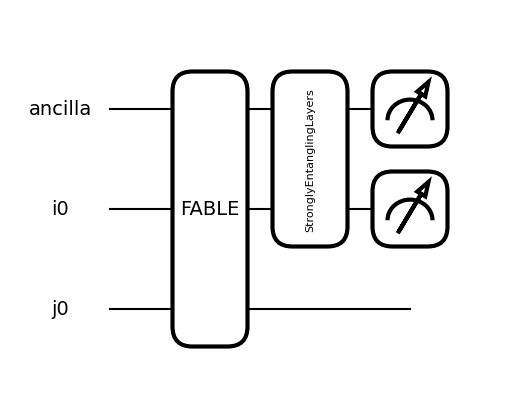

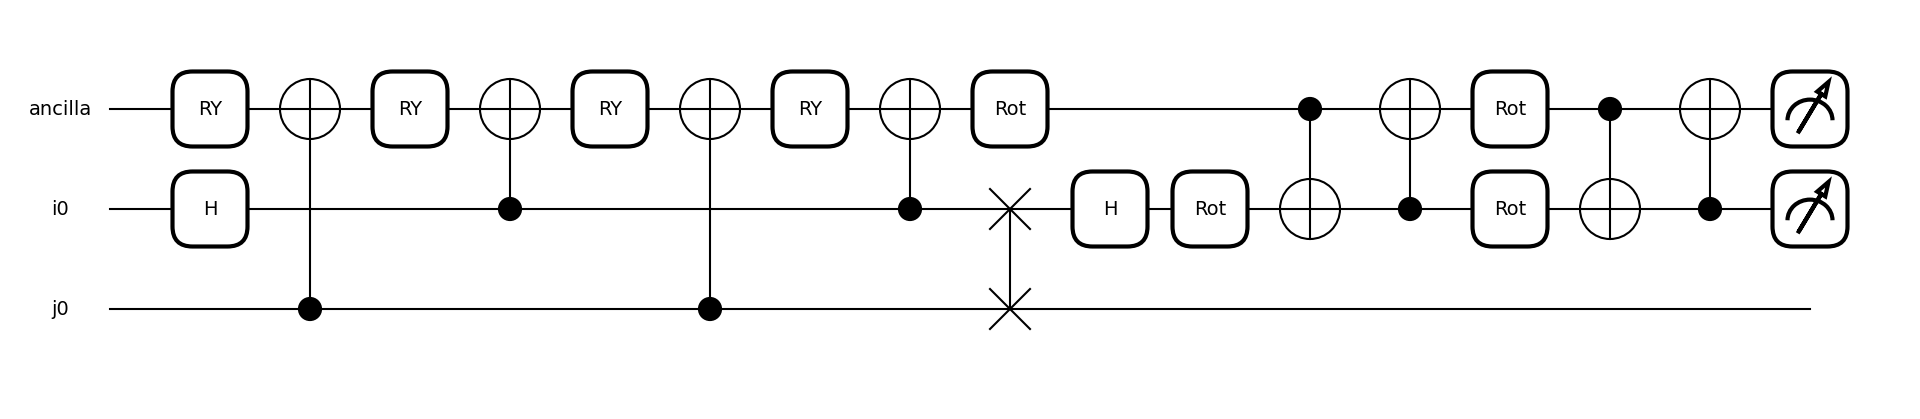

In [24]:
print(qml.draw(qlayer, expansion_strategy="device")(input_matrix, weights))
fig1, ax = qml.draw_mpl(qlayer)(input_matrix, weights)
fig2, ax = qml.draw_mpl(qlayer, expansion_strategy="device")(input_matrix, weights)